# EXPLORATION_12

In [55]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

 Movielens 1M Dataset를 사용하여 Session based Recommendation 시스템을 제작해보기

In [56]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


## Step 1. 데이터의 전처리

유저수(세션 수)와 아이템 수 확인하기

In [57]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

유저의 수 : 6040개, 아이템 수 : 3706개 

### Session Id 만들기

In [58]:
Session_id = []

pre_time = 0
pre_user = 0
now_session = 0

for line in data.iloc:
    if line['Time'] - pre_time > 1800 or pre_user != line['UserId']:    # 30분 = 1800초
        now_session +=1
    pre_time = line['Time']
    pre_user = line['UserId']
    Session_id.append(now_session)
    
data['SessionId'] = Session_id   

In [59]:
data

,UserId,ItemId,Rating,Time,SessionId
31,1,3186,4,978300019,1
22,1,1270,5,978300055,1
27,1,1721,4,978300055,1
37,1,1022,5,978300055,1
24,1,2340,3,978300103,1
...,...,...,...,...,...
1000019,6040,2917,4,997454429,25162
999988,6040,1921,4,997454464,25162
1000172,6040,1784,3,997454464,25162
1000167,6040,161,3,997454486,25162


In [60]:
data['SessionId'].nunique() # 세션의 숫자는 25163개

25163

In [61]:
# timestamp 시간 변환
data['DateTime'] = pd.to_datetime(data['Time'], unit='s')

### Session Length

각 세션에 대략 몇 개의 클릭 데이터가 존재하는지 확인

In [62]:
session_length = data.groupby('SessionId').size()
session_length

SessionId
1         40
2         13
3        129
4         51
5         21
        ... 
25159      7
25160     14
25161      1
25162     21
25163      1
Length: 25163, dtype: int64

In [63]:
session_length.median(), session_length.mean()

(6.0, 39.74919524698963)

In [64]:
session_length.min(), session_length.max()

(1, 1193)

In [65]:
session_length.quantile(0.999)

764.3520000000135

* 각 세션의 길이: 보통 6 ~ 39 정도 => 한명의 유저가 영화 평점을 6 ~ 39개 정도 매긴게 아닐까.. <br>
* 99.9% 세션은 길이가 764이하인데 길이가 1193인 세션은 좀 이상한거 같다.확인해보자!



In [66]:
long_session = session_length[session_length==1193].index[0]
data[data['SessionId']==long_session]

,UserId,ItemId,Rating,Time,SessionId,DateTime
637775,3841,1480,3,965995059,16446,2000-08-11 11:57:39
637808,3841,969,5,965995059,16446,2000-08-11 11:57:39
638269,3841,858,5,965995059,16446,2000-08-11 11:57:39
638716,3841,2019,5,965995059,16446,2000-08-11 11:57:39
638733,3841,1221,5,965995059,16446,2000-08-11 11:57:39
...,...,...,...,...,...,...
638038,3841,3806,5,966003791,16446,2000-08-11 14:23:11
638243,3841,1379,2,966003791,16446,2000-08-11 14:23:11
638459,3841,1928,4,966003791,16446,2000-08-11 14:23:11
638710,3841,2016,3,966003791,16446,2000-08-11 14:23:11


세션 길이 파악을 위해 시각화를 해보기 => 세션길이를 기준으로 하위 99.9%까지의 분포 누적합 시각화

In [67]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1      0.273378
2      0.373882
3      0.424115
4      0.456543
5      0.483726
         ...   
729    0.998808
735    0.998848
744    0.998887
746    0.998927
761    0.998967
Length: 532, dtype: float64

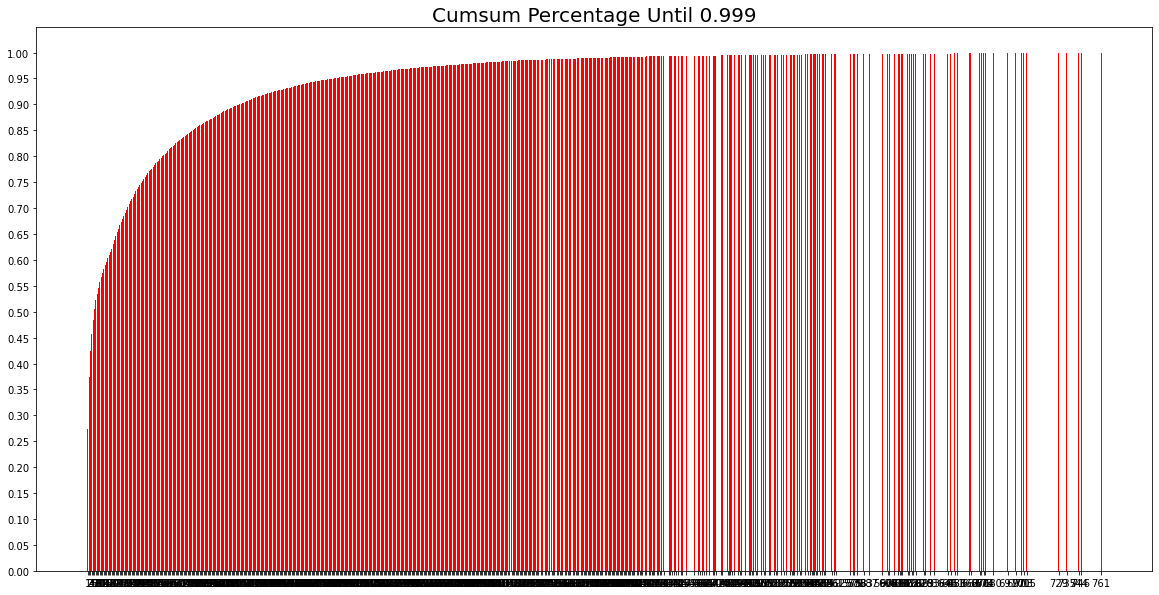

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

### Session Time

In [69]:
oldest, latest = data['DateTime'].min(), data['DateTime'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


약 3년치의 데이터가 있는데 1년치 데이터만 사용하겠다. 몇달치 혹은 2년치 데이터를 사용하면 성능이 더 좋아질까?

In [70]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

In [71]:
month_ago = latest - dt.timedelta(365)     # 최종 날짜로부터 1년 이전 날짜를 구한다.  
year1_data = data[data['DateTime'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
year1_data

,UserId,ItemId,Rating,Time,SessionId,DateTime
5170,36,1387,5,1015904819,86,2002-03-12 03:46:59
5267,36,1201,4,1015904819,86,2002-03-12 03:46:59
5122,36,1291,5,1015904836,86,2002-03-12 03:47:16
5123,36,2167,5,1015904905,86,2002-03-12 03:48:25
5290,36,2951,4,1015904905,86,2002-03-12 03:48:25
...,...,...,...,...,...,...
992358,5996,3835,3,1020113184,25051,2002-04-29 20:46:24
992279,5996,2422,3,1020113225,25051,2002-04-29 20:47:05
992702,5996,168,3,1031058746,25052,2002-09-03 13:12:26
992459,5996,339,4,1033997079,25053,2002-10-07 13:24:39


In [72]:
year1_data_oldest, year1_data_latest = year1_data['DateTime'].min(), year1_data['DateTime'].max()
print(year1_data_oldest) 
print(year1_data_latest)

2002-02-28 19:06:39
2003-02-28 17:49:50


### Data Cleaning
* 길이가 1인 세션은 제거하기
* 상대적으로 적게 클릭된 아이템도 이상한 아이템일 확률이 높기 때문에 제거해주기

In [73]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [74]:
year1_data = cleanse_recursive(year1_data, shortest=2, least_click=5)
year1_data

,UserId,ItemId,Rating,Time,SessionId,DateTime
5170,36,1387,5,1015904819,86,2002-03-12 03:46:59
5267,36,1201,4,1015904819,86,2002-03-12 03:46:59
5122,36,1291,5,1015904836,86,2002-03-12 03:47:16
5123,36,2167,5,1015904905,86,2002-03-12 03:48:25
5290,36,2951,4,1015904905,86,2002-03-12 03:48:25
...,...,...,...,...,...,...
992689,5996,2701,3,1020111976,25051,2002-04-29 20:26:16
992304,5996,2471,2,1020112109,25051,2002-04-29 20:28:29
992466,5996,3564,3,1020112392,25051,2002-04-29 20:33:12
992358,5996,3835,3,1020113184,25051,2002-04-29 20:46:24


### Train/ Valid/ Test split
 Valid Set과 Test Set 만들기

마지막 30일 기간 동안을 Test로 하고 60~30일전 까지를 valid set으로 나눔

In [78]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['DateTime'].max()
    session_last_time = data.groupby('SessionId')['DateTime'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [79]:
tr, test = split_by_date(year1_data, n_days=30)
tr, val = split_by_date(tr, n_days=30)

In [80]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["DateTime"].min()}\n'
          f'\t Last Time : {data["DateTime"].max()}\n')

In [81]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 13989
	 Sessions: 1182
	 Items: 1414
	 First Time : 2002-02-28 19:06:39
	 Last Time : 2002-12-30 01:53:41

* valid Set Stats Info
	 Events: 1432
	 Sessions: 125
	 Items: 841
	 First Time : 2002-12-30 16:38:06
	 Last Time : 2003-01-29 06:58:42

* test Set Stats Info
	 Events: 1233
	 Sessions: 84
	 Items: 778
	 First Time : 2003-01-29 19:36:56
	 Last Time : 2003-02-28 17:49:50



In [82]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [84]:
tr

,UserId,ItemId,Rating,Time,SessionId,DateTime,item_idx
5170,36,1387,5,1015904819,86,2002-03-12 03:46:59,0
5267,36,1201,4,1015904819,86,2002-03-12 03:46:59,1
5122,36,1291,5,1015904836,86,2002-03-12 03:47:16,2
5123,36,2167,5,1015904905,86,2002-03-12 03:48:25,3
5290,36,2951,4,1015904905,86,2002-03-12 03:48:25,4
...,...,...,...,...,...,...,...
992689,5996,2701,3,1020111976,25051,2002-04-29 20:26:16,969
992304,5996,2471,2,1020112109,25051,2002-04-29 20:28:29,742
992466,5996,3564,3,1020112392,25051,2002-04-29 20:33:12,611
992358,5996,3835,3,1020113184,25051,2002-04-29 20:46:24,1306


In [85]:
val

,UserId,ItemId,Rating,Time,SessionId,DateTime,item_idx
8704,59,2997,4,1041962568,130,2003-01-07 18:02:48,36
8781,59,2369,4,1041962664,130,2003-01-07 18:04:24,21
8797,59,3408,4,1041962692,130,2003-01-07 18:04:52,180
8808,59,2712,3,1041962692,130,2003-01-07 18:04:52,404
8809,59,2716,3,1041962731,130,2003-01-07 18:05:31,319
...,...,...,...,...,...,...,...
983989,5948,224,4,1043068072,24846,2003-01-20 13:07:52,145
984167,5948,1283,5,1043068249,24846,2003-01-20 13:10:49,15
984206,5948,1304,5,1043068456,24846,2003-01-20 13:14:16,624
984173,5948,1288,4,1043068509,24846,2003-01-20 13:15:09,910


In [86]:
test

,UserId,ItemId,Rating,Time,SessionId,DateTime,item_idx
28281,195,410,2,1044987808,988,2003-02-11 18:23:28,861
28389,195,2791,3,1044987808,988,2003-02-11 18:23:28,226
28391,195,2792,2,1044987808,988,2003-02-11 18:23:28,526
27781,195,3007,4,1044987990,988,2003-02-11 18:26:30,867
27764,195,1183,3,1044988494,988,2003-02-11 18:34:54,630
...,...,...,...,...,...,...,...
984731,5950,3948,4,1046369637,24868,2003-02-27 18:13:57,392
984682,5950,3578,4,1046369670,24868,2003-02-27 18:14:30,377
984475,5950,3793,3,1046369710,24868,2003-02-27 18:15:10,959
984660,5950,3555,2,1046369737,24868,2003-02-27 18:15:37,385


데이터 저장 후 data pipeline을 구축해보겠다!

In [87]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## Step 2. 미니 배치의 구성

### SessionDataset

In [88]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [89]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,SessionId,DateTime,item_idx
5170,36,1387,5,1015904819,86,2002-03-12 03:46:59,0
5267,36,1201,4,1015904819,86,2002-03-12 03:46:59,1
5122,36,1291,5,1015904836,86,2002-03-12 03:47:16,2
5123,36,2167,5,1015904905,86,2002-03-12 03:48:25,3
5290,36,2951,4,1015904905,86,2002-03-12 03:48:25,4
5359,36,2115,5,1015904905,86,2002-03-12 03:48:25,5
5073,36,1912,5,1015904924,86,2002-03-12 03:48:44,6
5113,36,2662,3,1015904924,86,2002-03-12 03:48:44,7
5366,36,2985,4,1015904941,86,2002-03-12 03:49:01,8
5145,36,198,5,1015904988,86,2002-03-12 03:49:48,9


In [90]:
tr_dataset.click_offsets

array([    0,    15,    17, ..., 13879, 13930, 13989], dtype=int32)

In [91]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 1179, 1180, 1181])

### SessionDataLoader

In [92]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [94]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,SessionId,DateTime,item_idx
5170,36,1387,5,1015904819,86,2002-03-12 03:46:59,0
5267,36,1201,4,1015904819,86,2002-03-12 03:46:59,1
5122,36,1291,5,1015904836,86,2002-03-12 03:47:16,2
5123,36,2167,5,1015904905,86,2002-03-12 03:48:25,3
5290,36,2951,4,1015904905,86,2002-03-12 03:48:25,4
5359,36,2115,5,1015904905,86,2002-03-12 03:48:25,5
5073,36,1912,5,1015904924,86,2002-03-12 03:48:44,6
5113,36,2662,3,1015904924,86,2002-03-12 03:48:44,7
5366,36,2985,4,1015904941,86,2002-03-12 03:49:01,8
5145,36,198,5,1015904988,86,2002-03-12 03:49:48,9


In [95]:
iter_ex = iter(tr_data_loader)

In [96]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 15 17 30]
Label Item Idx are :       [ 1 16 18 31]
Previous Masked Input Idx are []


## Step 3. 모델 구성

### Evaluation Metric
여기선 recall@k와 MRR을 사용

In [97]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### Model Architecture

In [98]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [101]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

 hyper-parameter를 class형식으로 관리

In [111]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=20, k=20)

In [112]:
model = create_model(args)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(64, 1, 1414)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      219900    
_________________________________________________________________
dropout_2 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_2 (Dense)              (64, 1414)                72114     
Total params: 292,014
Trainable params: 292,014
Non-trainable params: 0
_________________________________________________________________


## Step 4. 모델 학습

In [113]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [114]:
import time
start = time.time()

# 학습 시간이 다소 오래 소요됩니다. (예상시간 1시간)
train_model(model, args)


print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

Train:   0%|          | 0/200 [00:00<?, ?it/s, accuracy=0, train_loss=7.12]     

	 - Recall@20 epoch 1: 0.058594
	 - MRR@20    epoch 1: 0.013445



Train:   0%|          | 0/200 [00:00<?, ?it/s, accuracy=0, train_loss=7.12]     

	 - Recall@20 epoch 2: 0.070312
	 - MRR@20    epoch 2: 0.010790



Train:   0%|          | 0/200 [00:00<?, ?it/s, accuracy=0, train_loss=6.98]     

	 - Recall@20 epoch 3: 0.035156
	 - MRR@20    epoch 3: 0.009119



Train:   0%|          | 0/200 [00:00<?, ?it/s, accuracy=0, train_loss=7.02]     

	 - Recall@20 epoch 4: 0.046875
	 - MRR@20    epoch 4: 0.008182



Train:   0%|          | 0/200 [00:00<?, ?it/s, accuracy=0, train_loss=6.92]     

	 - Recall@20 epoch 5: 0.058594
	 - MRR@20    epoch 5: 0.010986



Train:   0%|          | 0/200 [00:00<?, ?it/s, accuracy=0, train_loss=6.85]     

	 - Recall@20 epoch 6: 0.042969
	 - MRR@20    epoch 6: 0.008686



Train:   0%|          | 0/200 [00:00<?, ?it/s, accuracy=0, train_loss=6.81]     

	 - Recall@20 epoch 7: 0.035156
	 - MRR@20    epoch 7: 0.008451



Train:   0%|          | 0/200 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.92]

	 - Recall@20 epoch 8: 0.062500
	 - MRR@20    epoch 8: 0.012857



Train:   0%|          | 0/200 [00:00<?, ?it/s, accuracy=0, train_loss=6.75]     

	 - Recall@20 epoch 9: 0.074219
	 - MRR@20    epoch 9: 0.018361



Train:   0%|          | 0/200 [00:00<?, ?it/s, accuracy=0, train_loss=6.7]      

	 - Recall@20 epoch 10: 0.070312
	 - MRR@20    epoch 10: 0.019305



Train:   0%|          | 0/200 [00:00<?, ?it/s, accuracy=0, train_loss=6.66]     

	 - Recall@20 epoch 11: 0.082031
	 - MRR@20    epoch 11: 0.021334



Train:   0%|          | 0/200 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.61]

	 - Recall@20 epoch 12: 0.082031
	 - MRR@20    epoch 12: 0.027206



Train:   0%|          | 0/200 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.47]

	 - Recall@20 epoch 13: 0.078125
	 - MRR@20    epoch 13: 0.035186



Train:   0%|          | 0/200 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.29]

	 - Recall@20 epoch 14: 0.074219
	 - MRR@20    epoch 14: 0.039003



Train:   0%|          | 0/200 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.2] 

	 - Recall@20 epoch 15: 0.074219
	 - MRR@20    epoch 15: 0.042786



Train:   0%|          | 0/200 [00:00<?, ?it/s, accuracy=0.0781, train_loss=6.03]

	 - Recall@20 epoch 16: 0.082031
	 - MRR@20    epoch 16: 0.044663



Train:   0%|          | 0/200 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.99]

	 - Recall@20 epoch 17: 0.089844
	 - MRR@20    epoch 17: 0.044783



Train:   0%|          | 0/200 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.73]

	 - Recall@20 epoch 18: 0.089844
	 - MRR@20    epoch 18: 0.043680



Train:   0%|          | 0/200 [00:00<?, ?it/s, accuracy=0.172, train_loss=5.57] 

	 - Recall@20 epoch 19: 0.101562
	 - MRR@20    epoch 19: 0.043408



Evaluation:  20%|██        | 4/20 [00:01<00:06,  2.54it/s]

	 - Recall@20 epoch 20: 0.101562
	 - MRR@20    epoch 20: 0.043957

time : 64.89147686958313


## Step 5. 모델 테스트
미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.

In [115]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  12%|█▏        | 2/17 [00:00<00:06,  2.44it/s]

	 - Recall@20: 0.039062
	 - MRR@20: 0.013897



## 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험

## 1. 세션, 하이퍼파라미터 변경
 기존 : least_click=5, 3년치데이터중 1년치만 사용

###  1-1. least_click = 20으로 변경, batch_size =32

In [120]:
month_ago = latest - dt.timedelta(365)     # 최종 날짜로부터 1년 이전 날짜를 구한다.  
year1_data = data[data['DateTime'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
year1_data = cleanse_recursive(year1_data, shortest=2, least_click=20)
year1_data

,UserId,ItemId,Rating,Time,SessionId,DateTime
5122,36,1291,5,1015904836,86,2002-03-12 03:47:16
5359,36,2115,5,1015904905,86,2002-03-12 03:48:25
5222,36,296,5,1040545019,89,2002-12-22 08:16:59
5062,36,1266,5,1040545109,89,2002-12-22 08:18:29
5076,36,595,4,1040545109,89,2002-12-22 08:18:29
...,...,...,...,...,...,...
992246,5996,3039,4,1020109564,25051,2002-04-29 19:46:04
992203,5996,3791,3,1020110319,25051,2002-04-29 19:58:39
992571,5996,3247,4,1020110717,25051,2002-04-29 20:05:17
992355,5996,3826,1,1020111017,25051,2002-04-29 20:10:17


In [121]:
tr, test = split_by_date(year1_data, n_days=30)
tr, val = split_by_date(tr, n_days=30)

# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

save_path = data_path / 'processed_click20'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

In [123]:
args = Args(tr, val, test, batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=20, k=20)
model = create_model(args)
train_model(model, args)
test_model(model, args, test)

Train:   0%|          | 0/85 [00:00<?, ?it/s]

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(32, 1, 153)]            0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      30750     
_________________________________________________________________
dropout_6 (Dropout)          (32, 50)                  0         
_________________________________________________________________
dense_6 (Dense)              (32, 153)                 7803      
Total params: 38,553
Trainable params: 38,553
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0, train_loss=5.02]     

	 - Recall@20 epoch 1: 0.187500
	 - MRR@20    epoch 1: 0.032984



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.01]

	 - Recall@20 epoch 2: 0.242188
	 - MRR@20    epoch 2: 0.068055



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0, train_loss=5]        

	 - Recall@20 epoch 3: 0.210938
	 - MRR@20    epoch 3: 0.070432



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.0312, train_loss=4.98]

	 - Recall@20 epoch 4: 0.210938
	 - MRR@20    epoch 4: 0.061726



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.0625, train_loss=4.94]

	 - Recall@20 epoch 5: 0.218750
	 - MRR@20    epoch 5: 0.070256



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.0625, train_loss=4.88]

	 - Recall@20 epoch 6: 0.242188
	 - MRR@20    epoch 6: 0.084626



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.0625, train_loss=4.84]

	 - Recall@20 epoch 7: 0.281250
	 - MRR@20    epoch 7: 0.105357



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.0625, train_loss=4.76]

	 - Recall@20 epoch 8: 0.296875
	 - MRR@20    epoch 8: 0.111479



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.0938, train_loss=4.59]

	 - Recall@20 epoch 9: 0.296875
	 - MRR@20    epoch 9: 0.125445



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.0938, train_loss=4.6] 

	 - Recall@20 epoch 10: 0.296875
	 - MRR@20    epoch 10: 0.140491



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.55] 

	 - Recall@20 epoch 11: 0.320312
	 - MRR@20    epoch 11: 0.139796



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.0938, train_loss=4.41]

	 - Recall@20 epoch 12: 0.320312
	 - MRR@20    epoch 12: 0.146503



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.0938, train_loss=4.4] 

	 - Recall@20 epoch 13: 0.335938
	 - MRR@20    epoch 13: 0.146041



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.0938, train_loss=4.23]

	 - Recall@20 epoch 14: 0.351562
	 - MRR@20    epoch 14: 0.158164



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.156, train_loss=4.01] 

	 - Recall@20 epoch 15: 0.359375
	 - MRR@20    epoch 15: 0.167125



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.0938, train_loss=4.2] 

	 - Recall@20 epoch 16: 0.359375
	 - MRR@20    epoch 16: 0.173752



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.15] 

	 - Recall@20 epoch 17: 0.351562
	 - MRR@20    epoch 17: 0.173969



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.312, train_loss=3.73] 

	 - Recall@20 epoch 18: 0.320312
	 - MRR@20    epoch 18: 0.178721



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.344, train_loss=3.7]  

	 - Recall@20 epoch 19: 0.328125
	 - MRR@20    epoch 19: 0.177047



Evaluation:  11%|█         | 1/9 [00:00<00:01,  5.32it/s]

	 - Recall@20 epoch 20: 0.359375
	 - MRR@20    epoch 20: 0.170999

	 - Recall@20: 0.312500
	 - MRR@20: 0.140393



|평가지표|변경 전|변경 후|
|---|---|---|
|Recall|0.039062|0.312500|
|MRR|0.013897|0.140393|

* 성능이 매우 좋아졌다.

### 1-2. 3년치 데이터 중 2년치 사용하기, val과 test는 3개월씩

In [132]:
month_ago = latest - dt.timedelta(730)     # 최종 날짜로부터 2년 이전 날짜를 구한다.  
year2_data = data[data['DateTime'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
year2_data = cleanse_recursive(year2_data, shortest=2, least_click=20)
year2_data

,UserId,ItemId,Rating,Time,SessionId,DateTime
2327,19,318,4,994556598,43,2001-07-08 01:43:18
2492,19,1234,5,994556636,43,2001-07-08 01:43:56
2503,20,1694,3,1009669071,45,2001-12-29 23:37:51
2513,20,3717,2,1009669071,45,2001-12-29 23:37:51
2517,20,2858,4,1009669071,45,2001-12-29 23:37:51
...,...,...,...,...,...,...
999923,6040,232,5,997454398,25162,2001-08-10 14:39:58
1000019,6040,2917,4,997454429,25162,2001-08-10 14:40:29
999988,6040,1921,4,997454464,25162,2001-08-10 14:41:04
1000172,6040,1784,3,997454464,25162,2001-08-10 14:41:04


In [133]:
tr, test = split_by_date(year2_data, n_days=90) # 3개월
tr, val = split_by_date(tr, n_days=90) # 3개월

# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

save_path = data_path / 'processed_year2'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

In [134]:
args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=20, k=20)
model = create_model(args)
train_model(model, args)
test_model(model, args, test)

Train:   0%|          | 0/612 [00:00<?, ?it/s]

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(64, 1, 1123)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      176250    
_________________________________________________________________
dropout_12 (Dropout)         (64, 50)                  0         
_________________________________________________________________
dense_12 (Dense)             (64, 1123)                57273     
Total params: 233,523
Trainable params: 233,523
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/612 [00:00<?, ?it/s, accuracy=0, train_loss=6.8]      

	 - Recall@20 epoch 1: 0.053309
	 - MRR@20    epoch 1: 0.012765



Train:   0%|          | 0/612 [00:00<?, ?it/s, accuracy=0, train_loss=6.73]     

	 - Recall@20 epoch 2: 0.056066
	 - MRR@20    epoch 2: 0.014210



Train:   0%|          | 0/612 [00:00<?, ?it/s, accuracy=0, train_loss=6.66]     

	 - Recall@20 epoch 3: 0.077206
	 - MRR@20    epoch 3: 0.018526



Train:   0%|          | 0/612 [00:00<?, ?it/s, accuracy=0, train_loss=6.42]     

	 - Recall@20 epoch 4: 0.091912
	 - MRR@20    epoch 4: 0.024327



Train:   0%|          | 0/612 [00:00<?, ?it/s, accuracy=0, train_loss=6.29]     

	 - Recall@20 epoch 5: 0.100184
	 - MRR@20    epoch 5: 0.028880



Train:   0%|          | 0/612 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.19]

	 - Recall@20 epoch 6: 0.116728
	 - MRR@20    epoch 6: 0.032074



Train:   0%|          | 0/612 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.96]

	 - Recall@20 epoch 7: 0.134191
	 - MRR@20    epoch 7: 0.036502



Train:   0%|          | 0/612 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.89]

	 - Recall@20 epoch 8: 0.155331
	 - MRR@20    epoch 8: 0.040308



Train:   0%|          | 0/612 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.83]

	 - Recall@20 epoch 9: 0.159926
	 - MRR@20    epoch 9: 0.043091



Train:   0%|          | 0/612 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.73]

	 - Recall@20 epoch 10: 0.171875
	 - MRR@20    epoch 10: 0.045215



Train:   0%|          | 0/612 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.62]

	 - Recall@20 epoch 11: 0.161765
	 - MRR@20    epoch 11: 0.047023



Train:   0%|          | 0/612 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.48]

	 - Recall@20 epoch 12: 0.156250
	 - MRR@20    epoch 12: 0.047374



Train:   0%|          | 0/612 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.48]

	 - Recall@20 epoch 13: 0.163603
	 - MRR@20    epoch 13: 0.048477



Train:   0%|          | 0/612 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.37]

	 - Recall@20 epoch 14: 0.164522
	 - MRR@20    epoch 14: 0.047857



Train:   0%|          | 0/612 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.27]

	 - Recall@20 epoch 15: 0.165441
	 - MRR@20    epoch 15: 0.048993



Train:   0%|          | 0/612 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.2] 

	 - Recall@20 epoch 16: 0.165441
	 - MRR@20    epoch 16: 0.048126



Train:   0%|          | 0/612 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.05]

	 - Recall@20 epoch 17: 0.166360
	 - MRR@20    epoch 17: 0.049718



Train:   0%|          | 0/612 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.16]

	 - Recall@20 epoch 18: 0.167279
	 - MRR@20    epoch 18: 0.049979



Train:   0%|          | 0/612 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.01]

	 - Recall@20 epoch 19: 0.160846
	 - MRR@20    epoch 19: 0.050054



Evaluation:   0%|          | 0/46 [00:00<?, ?it/s]

	 - Recall@20 epoch 20: 0.160846
	 - MRR@20    epoch 20: 0.051172



Evaluation:  48%|████▊     | 22/46 [00:08<00:09,  2.66it/s]

	 - Recall@20: 0.162642
	 - MRR@20: 0.055901



|평가지표|변경 전|변경 후(1-2)|1-1.click20경우|
|---|---|---|---|
|Recall|0.039062|0.162642|0.312500|
|MRR|0.013897|0.055901|0.140393|





* 기존보다 성능이 좋아졌다. 하지만 1-1. least_click을 5-> 20으로 바꾼 경우의 성능보다는 낮다.

### => batch_size를 64에서 32로 바꿔본다면?

In [135]:
args = Args(tr, val, test, batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=20, k=20)
model = create_model(args)
train_model(model, args)
test_model(model, args, test)

Train:   0%|          | 0/1224 [00:00<?, ?it/s]

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(32, 1, 1123)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      176250    
_________________________________________________________________
dropout_13 (Dropout)         (32, 50)                  0         
_________________________________________________________________
dense_13 (Dense)             (32, 1123)                57273     
Total params: 233,523
Trainable params: 233,523
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/1224 [00:00<?, ?it/s, accuracy=0, train_loss=6.63]     

	 - Recall@20 epoch 1: 0.050926
	 - MRR@20    epoch 1: 0.011960



Train:   0%|          | 0/1224 [00:00<?, ?it/s, accuracy=0, train_loss=6.38]     

	 - Recall@20 epoch 2: 0.067708
	 - MRR@20    epoch 2: 0.019161



Train:   0%|          | 0/1224 [00:00<?, ?it/s, accuracy=0, train_loss=6.36]     

	 - Recall@20 epoch 3: 0.087963
	 - MRR@20    epoch 3: 0.024374



Train:   0%|          | 0/1224 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.94]

	 - Recall@20 epoch 4: 0.113426
	 - MRR@20    epoch 4: 0.028871



Train:   0%|          | 0/1224 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.73]

	 - Recall@20 epoch 5: 0.131366
	 - MRR@20    epoch 5: 0.034708



Train:   0%|          | 0/1224 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.57]

	 - Recall@20 epoch 6: 0.142940
	 - MRR@20    epoch 6: 0.037012



Train:   0%|          | 0/1224 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.39]

	 - Recall@20 epoch 7: 0.146991
	 - MRR@20    epoch 7: 0.039398



Train:   0%|          | 0/1224 [00:00<?, ?it/s, accuracy=0.125, train_loss=5.32] 

	 - Recall@20 epoch 8: 0.151042
	 - MRR@20    epoch 8: 0.042057



Train:   0%|          | 0/1224 [00:00<?, ?it/s, accuracy=0, train_loss=5.57]     

	 - Recall@20 epoch 9: 0.151620
	 - MRR@20    epoch 9: 0.041797



Train:   0%|          | 0/1224 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.54]

	 - Recall@20 epoch 10: 0.149884
	 - MRR@20    epoch 10: 0.041050



Train:   0%|          | 0/1224 [00:00<?, ?it/s, accuracy=0.156, train_loss=4.91] 

	 - Recall@20 epoch 11: 0.145833
	 - MRR@20    epoch 11: 0.042213



Train:   0%|          | 0/1224 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.28]

	 - Recall@20 epoch 12: 0.146412
	 - MRR@20    epoch 12: 0.041323



Train:   0%|          | 0/1224 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.79] 

	 - Recall@20 epoch 13: 0.141782
	 - MRR@20    epoch 13: 0.041508



Train:   0%|          | 0/1224 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.64] 

	 - Recall@20 epoch 14: 0.143519
	 - MRR@20    epoch 14: 0.039740



Train:   0%|          | 0/1224 [00:00<?, ?it/s, accuracy=0.0938, train_loss=4.71]

	 - Recall@20 epoch 15: 0.144676
	 - MRR@20    epoch 15: 0.039009



Train:   0%|          | 0/1224 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.52] 

	 - Recall@20 epoch 16: 0.137731
	 - MRR@20    epoch 16: 0.038227



Train:   0%|          | 0/1224 [00:00<?, ?it/s, accuracy=0.219, train_loss=4.72] 

	 - Recall@20 epoch 17: 0.137731
	 - MRR@20    epoch 17: 0.038140



Train:   0%|          | 0/1224 [00:00<?, ?it/s, accuracy=0.219, train_loss=4.3]  

	 - Recall@20 epoch 18: 0.134259
	 - MRR@20    epoch 18: 0.037820



Train:   0%|          | 0/1224 [00:00<?, ?it/s, accuracy=0.0938, train_loss=4.36]

	 - Recall@20 epoch 19: 0.136574
	 - MRR@20    epoch 19: 0.038465



Evaluation:   0%|          | 0/92 [00:00<?, ?it/s]

	 - Recall@20 epoch 20: 0.132523
	 - MRR@20    epoch 20: 0.038334



Evaluation:  70%|██████▉   | 64/92 [00:12<00:05,  4.98it/s]

	 - Recall@20: 0.181641
	 - MRR@20: 0.060916



* batch_size=64 일 때, Recall@20:0.162642 / MRR@20: 0.055901
* batch_size=32 일 때, Recall@20:0.181641/ MRR@20: 0.060916 => 성능이 좋아졌긴한데 비슷하다.

### 1-3. 3년치 데이터 중 2년치 사용하기, val과 test는 1개월씩

In [136]:
tr, test = split_by_date(year2_data, n_days=30) # 1개월
tr, val = split_by_date(tr, n_days=30) # 1개월

# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

save_path = data_path / 'processed_year2_30'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

In [137]:
args = Args(tr, val, test, batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=20, k=20)
model = create_model(args)
train_model(model, args)
test_model(model, args, test)

Train:   0%|          | 0/1330 [00:00<?, ?it/s]

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(32, 1, 1123)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      176250    
_________________________________________________________________
dropout_14 (Dropout)         (32, 50)                  0         
_________________________________________________________________
dense_14 (Dense)             (32, 1123)                57273     
Total params: 233,523
Trainable params: 233,523
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/1330 [00:00<?, ?it/s, accuracy=0, train_loss=6.74]     

	 - Recall@20 epoch 1: 0.052083
	 - MRR@20    epoch 1: 0.012520



Train:   0%|          | 0/1330 [00:00<?, ?it/s, accuracy=0, train_loss=6.51]     

	 - Recall@20 epoch 2: 0.097917
	 - MRR@20    epoch 2: 0.019950



Train:   0%|          | 0/1330 [00:00<?, ?it/s, accuracy=0, train_loss=6.2]      

	 - Recall@20 epoch 3: 0.131250
	 - MRR@20    epoch 3: 0.036018



Train:   0%|          | 0/1330 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.05]

	 - Recall@20 epoch 4: 0.152083
	 - MRR@20    epoch 4: 0.044818



Train:   0%|          | 0/1330 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.87]

	 - Recall@20 epoch 5: 0.172917
	 - MRR@20    epoch 5: 0.049443



Train:   0%|          | 0/1330 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.69]

	 - Recall@20 epoch 6: 0.197917
	 - MRR@20    epoch 6: 0.059186



Train:   0%|          | 0/1330 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.46]

	 - Recall@20 epoch 7: 0.208333
	 - MRR@20    epoch 7: 0.068996



Train:   0%|          | 0/1330 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.24]

	 - Recall@20 epoch 8: 0.218750
	 - MRR@20    epoch 8: 0.073231



Train:   0%|          | 0/1330 [00:00<?, ?it/s, accuracy=0.0625, train_loss=4.92]

	 - Recall@20 epoch 9: 0.222917
	 - MRR@20    epoch 9: 0.077164



Train:   0%|          | 0/1330 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.08]

	 - Recall@20 epoch 10: 0.212500
	 - MRR@20    epoch 10: 0.078165



Train:   0%|          | 0/1330 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.02]

	 - Recall@20 epoch 11: 0.214583
	 - MRR@20    epoch 11: 0.080251



Train:   0%|          | 0/1330 [00:00<?, ?it/s, accuracy=0.0625, train_loss=4.9] 

	 - Recall@20 epoch 12: 0.214583
	 - MRR@20    epoch 12: 0.078176



Train:   0%|          | 0/1330 [00:00<?, ?it/s, accuracy=0.0625, train_loss=4.93]

	 - Recall@20 epoch 13: 0.212500
	 - MRR@20    epoch 13: 0.079776



Train:   0%|          | 0/1330 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.54] 

	 - Recall@20 epoch 14: 0.216667
	 - MRR@20    epoch 14: 0.076635



Train:   0%|          | 0/1330 [00:00<?, ?it/s, accuracy=0.0938, train_loss=4.43]

	 - Recall@20 epoch 15: 0.218750
	 - MRR@20    epoch 15: 0.075372



Train:   0%|          | 0/1330 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.3]  

	 - Recall@20 epoch 16: 0.214583
	 - MRR@20    epoch 16: 0.076248



Train:   0%|          | 0/1330 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.28] 

	 - Recall@20 epoch 17: 0.212500
	 - MRR@20    epoch 17: 0.080366



Train:   0%|          | 0/1330 [00:00<?, ?it/s, accuracy=0.0625, train_loss=4.53]

	 - Recall@20 epoch 18: 0.202083
	 - MRR@20    epoch 18: 0.077223



Train:   0%|          | 0/1330 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.22] 

	 - Recall@20 epoch 19: 0.200000
	 - MRR@20    epoch 19: 0.075334



Evaluation:   0%|          | 0/31 [00:00<?, ?it/s]

	 - Recall@20 epoch 20: 0.202083
	 - MRR@20    epoch 20: 0.076565



Evaluation:  26%|██▌       | 8/31 [00:01<00:04,  4.96it/s]

	 - Recall@20: 0.160156
	 - MRR@20: 0.053640



* 2년치사용, val과 test는 3개월씩, batch_size 32 => Recall@20:0.181641/ MRR@20: 0.060916
* 2년치사용, val과 test는 1개월씩, batch_size 32 => Recall@20: 0.160156 /  MRR@20: 0.053640 => 비슷하게 나왔다. 

### => drop_rate 을 0.1에서 0.2로 바꾸면?

In [138]:
args = Args(tr, val, test, batch_size=32, hsz=50, drop_rate=0.2, lr=0.001, epochs=20, k=20)
model = create_model(args)
train_model(model, args)
test_model(model, args, test)

Train:   0%|          | 0/1330 [00:00<?, ?it/s]

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(32, 1, 1123)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      176250    
_________________________________________________________________
dropout_15 (Dropout)         (32, 50)                  0         
_________________________________________________________________
dense_15 (Dense)             (32, 1123)                57273     
Total params: 233,523
Trainable params: 233,523
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/1330 [00:00<?, ?it/s, accuracy=0, train_loss=6.77]     

	 - Recall@20 epoch 1: 0.054167
	 - MRR@20    epoch 1: 0.012224



Train:   0%|          | 0/1330 [00:00<?, ?it/s, accuracy=0, train_loss=6.38]     

	 - Recall@20 epoch 2: 0.081250
	 - MRR@20    epoch 2: 0.023766



Train:   0%|          | 0/1330 [00:00<?, ?it/s, accuracy=0, train_loss=6.29]     

	 - Recall@20 epoch 3: 0.112500
	 - MRR@20    epoch 3: 0.031124



Train:   0%|          | 0/1330 [00:00<?, ?it/s, accuracy=0, train_loss=6.08]     

	 - Recall@20 epoch 4: 0.143750
	 - MRR@20    epoch 4: 0.046177



Train:   0%|          | 0/1330 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.66]

	 - Recall@20 epoch 5: 0.160417
	 - MRR@20    epoch 5: 0.051683



Train:   0%|          | 0/1330 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.76]

	 - Recall@20 epoch 6: 0.170833
	 - MRR@20    epoch 6: 0.052373



Train:   0%|          | 0/1330 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.54]

	 - Recall@20 epoch 7: 0.168750
	 - MRR@20    epoch 7: 0.063135



Train:   0%|          | 0/1330 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.46]

	 - Recall@20 epoch 8: 0.179167
	 - MRR@20    epoch 8: 0.065062



Train:   0%|          | 0/1330 [00:00<?, ?it/s, accuracy=0, train_loss=5.36]     

	 - Recall@20 epoch 9: 0.189583
	 - MRR@20    epoch 9: 0.067447



Train:   0%|          | 0/1330 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.2] 

	 - Recall@20 epoch 10: 0.187500
	 - MRR@20    epoch 10: 0.068910



Train:   0%|          | 0/1330 [00:00<?, ?it/s, accuracy=0, train_loss=5.2]      

	 - Recall@20 epoch 11: 0.189583
	 - MRR@20    epoch 11: 0.066627



Train:   0%|          | 0/1330 [00:00<?, ?it/s, accuracy=0.0625, train_loss=4.88]

	 - Recall@20 epoch 12: 0.195833
	 - MRR@20    epoch 12: 0.068091



Train:   0%|          | 0/1330 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.01]

	 - Recall@20 epoch 13: 0.193750
	 - MRR@20    epoch 13: 0.066507



Train:   0%|          | 0/1330 [00:00<?, ?it/s, accuracy=0.156, train_loss=4.84] 

	 - Recall@20 epoch 14: 0.200000
	 - MRR@20    epoch 14: 0.070528



Train:   0%|          | 0/1330 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.02]

	 - Recall@20 epoch 15: 0.202083
	 - MRR@20    epoch 15: 0.070148



Train:   0%|          | 0/1330 [00:00<?, ?it/s, accuracy=0.188, train_loss=4.64] 

	 - Recall@20 epoch 16: 0.200000
	 - MRR@20    epoch 16: 0.069192



Train:   0%|          | 0/1330 [00:00<?, ?it/s, accuracy=0.0938, train_loss=4.63]

	 - Recall@20 epoch 17: 0.200000
	 - MRR@20    epoch 17: 0.070785



Train:   0%|          | 0/1330 [00:00<?, ?it/s, accuracy=0.0938, train_loss=4.77]

	 - Recall@20 epoch 18: 0.202083
	 - MRR@20    epoch 18: 0.071847



Train:   0%|          | 0/1330 [00:00<?, ?it/s, accuracy=0.0625, train_loss=4.44]

	 - Recall@20 epoch 19: 0.197917
	 - MRR@20    epoch 19: 0.072278



Evaluation:   0%|          | 0/31 [00:00<?, ?it/s]

	 - Recall@20 epoch 20: 0.195833
	 - MRR@20    epoch 20: 0.072054



Evaluation:  26%|██▌       | 8/31 [00:01<00:04,  5.01it/s]

	 - Recall@20: 0.160156
	 - MRR@20: 0.047193



* 비슷한 결과가 나온다. MRR은 조금 감소했다.

### 1-4. 3년치 데이터 중 3년치 사용하기, val과 test는 3개월씩

In [139]:
year3_data = cleanse_recursive(data, shortest=2, least_click=20)
year3_data

,UserId,ItemId,Rating,Time,SessionId,DateTime
31,1,3186,4,978300019,1,2000-12-31 22:00:19
22,1,1270,5,978300055,1,2000-12-31 22:00:55
27,1,1721,4,978300055,1,2000-12-31 22:00:55
37,1,1022,5,978300055,1,2000-12-31 22:00:55
24,1,2340,3,978300103,1,2000-12-31 22:01:43
...,...,...,...,...,...,...
999923,6040,232,5,997454398,25162,2001-08-10 14:39:58
1000019,6040,2917,4,997454429,25162,2001-08-10 14:40:29
999988,6040,1921,4,997454464,25162,2001-08-10 14:41:04
1000172,6040,1784,3,997454464,25162,2001-08-10 14:41:04


In [140]:
tr, test = split_by_date(year3_data, n_days=90) # 3개월
tr, val = split_by_date(tr, n_days=90) # 3개월

# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

save_path = data_path / 'processed_year3'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

In [141]:
args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=20, k=20)
model = create_model(args)
train_model(model, args)
test_model(model, args, test)

Train:   0%|          | 0/15043 [00:00<?, ?it/s]

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(64, 1, 3025)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      461550    
_________________________________________________________________
dropout_16 (Dropout)         (64, 50)                  0         
_________________________________________________________________
dense_16 (Dense)             (64, 3025)                154275    
Total params: 615,825
Trainable params: 615,825
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/15043 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6]   

	 - Recall@20 epoch 1: 0.128125
	 - MRR@20    epoch 1: 0.030877



Train:   0%|          | 0/15043 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.87]

	 - Recall@20 epoch 2: 0.145000
	 - MRR@20    epoch 2: 0.037325



Train:   0%|          | 0/15043 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.89]

	 - Recall@20 epoch 3: 0.155625
	 - MRR@20    epoch 3: 0.044071



Train:   0%|          | 0/15043 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.82]

	 - Recall@20 epoch 4: 0.159375
	 - MRR@20    epoch 4: 0.045874



Train:   0%|          | 0/15043 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.54]

	 - Recall@20 epoch 5: 0.160625
	 - MRR@20    epoch 5: 0.046046



Train:   0%|          | 0/15043 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.73]

	 - Recall@20 epoch 6: 0.163125
	 - MRR@20    epoch 6: 0.048382



Train:   0%|          | 0/15043 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.75]

	 - Recall@20 epoch 7: 0.163125
	 - MRR@20    epoch 7: 0.048366



Train:   0%|          | 0/15043 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.41]

	 - Recall@20 epoch 8: 0.166250
	 - MRR@20    epoch 8: 0.048993



Train:   0%|          | 0/15043 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.76]

	 - Recall@20 epoch 9: 0.162500
	 - MRR@20    epoch 9: 0.047300



Train:   0%|          | 0/15043 [00:00<?, ?it/s, accuracy=0.0156, train_loss=5.81]

	 - Recall@20 epoch 10: 0.166250
	 - MRR@20    epoch 10: 0.049238



Train:   0%|          | 0/15043 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.7] 

	 - Recall@20 epoch 11: 0.169375
	 - MRR@20    epoch 11: 0.049409



Train:   0%|          | 0/15043 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.75]

	 - Recall@20 epoch 12: 0.169375
	 - MRR@20    epoch 12: 0.049033



Train:   0%|          | 0/15043 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.74]

	 - Recall@20 epoch 13: 0.169375
	 - MRR@20    epoch 13: 0.049437



Train:   0%|          | 0/15043 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.53]

	 - Recall@20 epoch 14: 0.166875
	 - MRR@20    epoch 14: 0.050107



Train:   0%|          | 0/15043 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.77]

	 - Recall@20 epoch 15: 0.165000
	 - MRR@20    epoch 15: 0.051450



Train:   0%|          | 0/15043 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.53]

	 - Recall@20 epoch 16: 0.163125
	 - MRR@20    epoch 16: 0.050279



Train:   0%|          | 0/15043 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.68]

	 - Recall@20 epoch 17: 0.164375
	 - MRR@20    epoch 17: 0.048088



Train:   0%|          | 0/15043 [00:00<?, ?it/s, accuracy=0.0156, train_loss=5.75]

	 - Recall@20 epoch 18: 0.165625
	 - MRR@20    epoch 18: 0.047241



Train:   0%|          | 0/15043 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.76]

	 - Recall@20 epoch 19: 0.164375
	 - MRR@20    epoch 19: 0.047511



Evaluation:   0%|          | 0/60 [00:00<?, ?it/s]

	 - Recall@20 epoch 20: 0.167500
	 - MRR@20    epoch 20: 0.045921



Evaluation:  50%|█████     | 30/60 [00:10<00:10,  2.74it/s]

	 - Recall@20: 0.190104
	 - MRR@20: 0.065721



*  Recall@20: 0.190104 /  MRR@20 : 0.065721  => 기존보다 좋아졌지만 다른 경우보단 성능이 낮다

###  => 데이터가 너무 많으므로 평점 3점대 이하 데이터 삭제하기

In [167]:
data_drop_3 = data.loc[data['Rating']>3]
data_drop_3

,UserId,ItemId,Rating,Time,SessionId,DateTime
31,1,3186,4,978300019,1,2000-12-31 22:00:19
22,1,1270,5,978300055,1,2000-12-31 22:00:55
27,1,1721,4,978300055,1,2000-12-31 22:00:55
37,1,1022,5,978300055,1,2000-12-31 22:00:55
36,1,1836,5,978300172,1,2000-12-31 22:02:52
...,...,...,...,...,...,...
1000119,6040,3671,4,997454367,25162,2001-08-10 14:39:27
999923,6040,232,5,997454398,25162,2001-08-10 14:39:58
1000019,6040,2917,4,997454429,25162,2001-08-10 14:40:29
999988,6040,1921,4,997454464,25162,2001-08-10 14:41:04


In [168]:
year3_data = cleanse_recursive(data_drop_3, shortest=2, least_click=20)
year3_data

,UserId,ItemId,Rating,Time,SessionId,DateTime
31,1,3186,4,978300019,1,2000-12-31 22:00:19
22,1,1270,5,978300055,1,2000-12-31 22:00:55
27,1,1721,4,978300055,1,2000-12-31 22:00:55
37,1,1022,5,978300055,1,2000-12-31 22:00:55
36,1,1836,5,978300172,1,2000-12-31 22:02:52
...,...,...,...,...,...,...
1000118,6040,457,4,997454349,25162,2001-08-10 14:39:09
1000119,6040,3671,4,997454367,25162,2001-08-10 14:39:27
999923,6040,232,5,997454398,25162,2001-08-10 14:39:58
1000019,6040,2917,4,997454429,25162,2001-08-10 14:40:29


In [169]:
tr, test = split_by_date(year3_data, n_days=30) # 3개월
tr, val = split_by_date(tr, n_days=30) # 3개월

# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

save_path = data_path / 'processed_year3_drop3'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

In [171]:
args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=20, k=20)
model = create_model(args)
train_model(model, args)
test_model(model, args, test)

Train:   0%|          | 0/8454 [00:00<?, ?it/s]

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(64, 1, 2372)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      363600    
_________________________________________________________________
dropout_22 (Dropout)         (64, 50)                  0         
_________________________________________________________________
dense_22 (Dense)             (64, 2372)                120972    
Total params: 484,572
Trainable params: 484,572
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/8454 [00:00<?, ?it/s, accuracy=0.0156, train_loss=5.85]

	 - Recall@20 epoch 1: 0.116587
	 - MRR@20    epoch 1: 0.027163



Train:   0%|          | 0/8454 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.41]

	 - Recall@20 epoch 2: 0.151442
	 - MRR@20    epoch 2: 0.038132



Train:   0%|          | 0/8454 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.06]

	 - Recall@20 epoch 3: 0.169471
	 - MRR@20    epoch 3: 0.042501



Train:   0%|          | 0/8454 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.3] 

	 - Recall@20 epoch 4: 0.176683
	 - MRR@20    epoch 4: 0.044913



Train:   0%|          | 0/8454 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.23]

	 - Recall@20 epoch 5: 0.175481
	 - MRR@20    epoch 5: 0.045569



Train:   0%|          | 0/8454 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.2] 

	 - Recall@20 epoch 6: 0.174279
	 - MRR@20    epoch 6: 0.045866



Train:   0%|          | 0/8454 [00:00<?, ?it/s, accuracy=0, train_loss=5.8]      

	 - Recall@20 epoch 7: 0.169471
	 - MRR@20    epoch 7: 0.045626



Train:   0%|          | 0/8454 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.12]

	 - Recall@20 epoch 8: 0.170673
	 - MRR@20    epoch 8: 0.044713



Train:   0%|          | 0/8454 [00:00<?, ?it/s, accuracy=0.0781, train_loss=4.96]

	 - Recall@20 epoch 9: 0.164663
	 - MRR@20    epoch 9: 0.044328



Train:   0%|          | 0/8454 [00:00<?, ?it/s, accuracy=0.109, train_loss=5.05] 

	 - Recall@20 epoch 10: 0.173077
	 - MRR@20    epoch 10: 0.044724



Train:   0%|          | 0/8454 [00:00<?, ?it/s, accuracy=0.0938, train_loss=4.93]

	 - Recall@20 epoch 11: 0.169471
	 - MRR@20    epoch 11: 0.045039



Train:   0%|          | 0/8454 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.08]

	 - Recall@20 epoch 12: 0.173077
	 - MRR@20    epoch 12: 0.045761



Train:   0%|          | 0/8454 [00:00<?, ?it/s, accuracy=0.0156, train_loss=5.78]

	 - Recall@20 epoch 13: 0.171875
	 - MRR@20    epoch 13: 0.044655



Train:   0%|          | 0/8454 [00:00<?, ?it/s, accuracy=0.0156, train_loss=5.7] 

	 - Recall@20 epoch 14: 0.169471
	 - MRR@20    epoch 14: 0.040331



Train:   0%|          | 0/8454 [00:00<?, ?it/s, accuracy=0.0781, train_loss=4.9] 

	 - Recall@20 epoch 15: 0.170673
	 - MRR@20    epoch 15: 0.041282



Train:   0%|          | 0/8454 [00:00<?, ?it/s, accuracy=0, train_loss=5.81]     

	 - Recall@20 epoch 16: 0.165865
	 - MRR@20    epoch 16: 0.043031



Train:   0%|          | 0/8454 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.73]

	 - Recall@20 epoch 17: 0.165865
	 - MRR@20    epoch 17: 0.040825



Train:   0%|          | 0/8454 [00:00<?, ?it/s, accuracy=0.0781, train_loss=4.92]

	 - Recall@20 epoch 18: 0.170673
	 - MRR@20    epoch 18: 0.041533



Train:   0%|          | 0/8454 [00:00<?, ?it/s, accuracy=0.0938, train_loss=4.93]

	 - Recall@20 epoch 19: 0.165865
	 - MRR@20    epoch 19: 0.042656



Evaluation:   0%|          | 0/30 [00:00<?, ?it/s]

	 - Recall@20 epoch 20: 0.170673
	 - MRR@20    epoch 20: 0.043633



Evaluation:  47%|████▋     | 14/30 [00:05<00:05,  2.73it/s]

	 - Recall@20: 0.162946
	 - MRR@20: 0.061167



* Recall@20: 0.162946 / MRR@20: 0.061167 => 평점데이터를 건드리지 않은 경우와 비슷하다.

## 2.😉 1-1. least_click = 20으로 변경, (batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=20, k=20)=> 이 경우가 제일 좋았기 때문에 이걸 더 변형해보겠다!
기존 결과 :  Recall@20: 0.312500 / MRR@20: 0.140393

In [188]:
month_ago = latest - dt.timedelta(365)     # 최종 날짜로부터 1년 이전 날짜를 구한다.  
year1_data = data[data['DateTime'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
year1_data = cleanse_recursive(year1_data, shortest=2, least_click=20)

tr, test = split_by_date(year1_data, n_days=30)
tr, val = split_by_date(tr, n_days=30)

# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

save_path = data_path / 'processed_click20'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')


In [190]:
args = Args(tr, val, test, batch_size=32, hsz=70, drop_rate=0.3, lr=0.001, epochs=20, k=20)
model = create_model(args)
train_model(model, args)
test_model(model, args, test)

Train:   0%|          | 0/85 [00:00<?, ?it/s]

Model: "model_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        [(32, 1, 153)]            0         
_________________________________________________________________
GRU (GRU)                    [(32, 70), (32, 70)]      47250     
_________________________________________________________________
dropout_36 (Dropout)         (32, 70)                  0         
_________________________________________________________________
dense_36 (Dense)             (32, 153)                 10863     
Total params: 58,113
Trainable params: 58,113
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0, train_loss=5.01]     

	 - Recall@20 epoch 1: 0.195312
	 - MRR@20    epoch 1: 0.030883



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.02]

	 - Recall@20 epoch 2: 0.218750
	 - MRR@20    epoch 2: 0.061171



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0, train_loss=4.99]     

	 - Recall@20 epoch 3: 0.234375
	 - MRR@20    epoch 3: 0.074158



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5]   

	 - Recall@20 epoch 4: 0.195312
	 - MRR@20    epoch 4: 0.060438



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.0312, train_loss=4.96]

	 - Recall@20 epoch 5: 0.234375
	 - MRR@20    epoch 5: 0.063826



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.156, train_loss=4.8]  

	 - Recall@20 epoch 6: 0.265625
	 - MRR@20    epoch 6: 0.085248



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.0938, train_loss=4.7] 

	 - Recall@20 epoch 7: 0.320312
	 - MRR@20    epoch 7: 0.111407



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.0312, train_loss=4.74]

	 - Recall@20 epoch 8: 0.312500
	 - MRR@20    epoch 8: 0.111860



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.0625, train_loss=4.67]

	 - Recall@20 epoch 9: 0.335938
	 - MRR@20    epoch 9: 0.125989



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.0938, train_loss=4.52]

	 - Recall@20 epoch 10: 0.367188
	 - MRR@20    epoch 10: 0.110218



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.41] 

	 - Recall@20 epoch 11: 0.359375
	 - MRR@20    epoch 11: 0.123646



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.0312, train_loss=4.37]

	 - Recall@20 epoch 12: 0.367188
	 - MRR@20    epoch 12: 0.131254



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.0625, train_loss=4.23]

	 - Recall@20 epoch 13: 0.382812
	 - MRR@20    epoch 13: 0.140558



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.0938, train_loss=4.17]

	 - Recall@20 epoch 14: 0.390625
	 - MRR@20    epoch 14: 0.139257



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.156, train_loss=4.06] 

	 - Recall@20 epoch 15: 0.390625
	 - MRR@20    epoch 15: 0.148062



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.0625, train_loss=3.99]

	 - Recall@20 epoch 16: 0.406250
	 - MRR@20    epoch 16: 0.144339



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.0625, train_loss=3.93]

	 - Recall@20 epoch 17: 0.414062
	 - MRR@20    epoch 17: 0.147908



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.219, train_loss=3.75] 

	 - Recall@20 epoch 18: 0.406250
	 - MRR@20    epoch 18: 0.147020



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.0938, train_loss=3.87]

	 - Recall@20 epoch 19: 0.406250
	 - MRR@20    epoch 19: 0.156039



Evaluation:  11%|█         | 1/9 [00:00<00:01,  5.69it/s]

	 - Recall@20 epoch 20: 0.414062
	 - MRR@20    epoch 20: 0.156412

	 - Recall@20: 0.375000
	 - MRR@20: 0.146947



* 기존보다 recall이 좀 높아졌다.

In [192]:
args = Args(tr, val, test, batch_size=32, hsz=70, drop_rate=0.3, lr=0.001, epochs=20, k=10)
model = create_model(args)
train_model(model, args)
test_model(model, args, test)

Train:   0%|          | 0/85 [00:00<?, ?it/s]

Model: "model_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        [(32, 1, 153)]            0         
_________________________________________________________________
GRU (GRU)                    [(32, 70), (32, 70)]      47250     
_________________________________________________________________
dropout_38 (Dropout)         (32, 70)                  0         
_________________________________________________________________
dense_38 (Dense)             (32, 153)                 10863     
Total params: 58,113
Trainable params: 58,113
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.01]

	 - Recall@10 epoch 1: 0.164062
	 - MRR@10    epoch 1: 0.060448



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.01]

	 - Recall@10 epoch 2: 0.171875
	 - MRR@10    epoch 2: 0.083104



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.0938, train_loss=4.96]

	 - Recall@10 epoch 3: 0.164062
	 - MRR@10    epoch 3: 0.079033



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.91] 

	 - Recall@10 epoch 4: 0.187500
	 - MRR@10    epoch 4: 0.086390



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.0938, train_loss=4.87]

	 - Recall@10 epoch 5: 0.195312
	 - MRR@10    epoch 5: 0.083061



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.0938, train_loss=4.81]

	 - Recall@10 epoch 6: 0.156250
	 - MRR@10    epoch 6: 0.095182



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.156, train_loss=4.7]  

	 - Recall@10 epoch 7: 0.187500
	 - MRR@10    epoch 7: 0.110100



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.61] 

	 - Recall@10 epoch 8: 0.226562
	 - MRR@10    epoch 8: 0.112912



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.0625, train_loss=4.71]

	 - Recall@10 epoch 9: 0.242188
	 - MRR@10    epoch 9: 0.121850



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.0938, train_loss=4.54]

	 - Recall@10 epoch 10: 0.234375
	 - MRR@10    epoch 10: 0.131758



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.48] 

	 - Recall@10 epoch 11: 0.234375
	 - MRR@10    epoch 11: 0.130205



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.37] 

	 - Recall@10 epoch 12: 0.250000
	 - MRR@10    epoch 12: 0.136483



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.15] 

	 - Recall@10 epoch 13: 0.242188
	 - MRR@10    epoch 13: 0.132788



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.0625, train_loss=4.31]

	 - Recall@10 epoch 14: 0.250000
	 - MRR@10    epoch 14: 0.144572



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.156, train_loss=4.08] 

	 - Recall@10 epoch 15: 0.250000
	 - MRR@10    epoch 15: 0.150651



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.156, train_loss=3.91] 

	 - Recall@10 epoch 16: 0.250000
	 - MRR@10    epoch 16: 0.153385



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.125, train_loss=3.83] 

	 - Recall@10 epoch 17: 0.257812
	 - MRR@10    epoch 17: 0.150908



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.188, train_loss=3.82] 

	 - Recall@10 epoch 18: 0.265625
	 - MRR@10    epoch 18: 0.153764



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.125, train_loss=3.74] 

	 - Recall@10 epoch 19: 0.265625
	 - MRR@10    epoch 19: 0.154402



Evaluation:  11%|█         | 1/9 [00:00<00:01,  5.06it/s]

	 - Recall@10 epoch 20: 0.265625
	 - MRR@10    epoch 20: 0.156495

	 - Recall@10: 0.281250
	 - MRR@10: 0.161892



* 기존보다 MRR이 좀 높아짐, Recall은 감소했다.

In [226]:
args = Args(tr, val, test, batch_size=32, hsz=70, drop_rate=0.25, lr=0.001, epochs=10, k=60)
model = create_model(args)
train_model(model, args)
test_model(model, args, test)

Train:   0%|          | 0/85 [00:00<?, ?it/s]

Model: "model_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_73 (InputLayer)        [(32, 1, 153)]            0         
_________________________________________________________________
GRU (GRU)                    [(32, 70), (32, 70)]      47250     
_________________________________________________________________
dropout_72 (Dropout)         (32, 70)                  0         
_________________________________________________________________
dense_72 (Dense)             (32, 153)                 10863     
Total params: 58,113
Trainable params: 58,113
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.01]

	 - Recall@60 epoch 1: 0.492188
	 - MRR@60    epoch 1: 0.039320



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.0625, train_loss=4.98]

	 - Recall@60 epoch 2: 0.507812
	 - MRR@60    epoch 2: 0.062276



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.0625, train_loss=4.96]

	 - Recall@60 epoch 3: 0.523438
	 - MRR@60    epoch 3: 0.073621



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.0312, train_loss=4.94]

	 - Recall@60 epoch 4: 0.500000
	 - MRR@60    epoch 4: 0.075670



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.0938, train_loss=4.85]

	 - Recall@60 epoch 5: 0.523438
	 - MRR@60    epoch 5: 0.088977



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.0312, train_loss=4.78]

	 - Recall@60 epoch 6: 0.531250
	 - MRR@60    epoch 6: 0.098912



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.0938, train_loss=4.67]

	 - Recall@60 epoch 7: 0.554688
	 - MRR@60    epoch 7: 0.103995



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.0938, train_loss=4.59]

	 - Recall@60 epoch 8: 0.609375
	 - MRR@60    epoch 8: 0.122348



Train:   0%|          | 0/85 [00:00<?, ?it/s, accuracy=0.156, train_loss=4.48] 

	 - Recall@60 epoch 9: 0.601562
	 - MRR@60    epoch 9: 0.128882



Evaluation:  11%|█         | 1/9 [00:00<00:01,  5.61it/s]

	 - Recall@60 epoch 10: 0.585938
	 - MRR@60    epoch 10: 0.131985

	 - Recall@60: 0.406250
	 - MRR@60: 0.164503



* 둘 다 증가하였다!

# 회고

### 1. 여러 실험 결과

|순서|데이터 개수(약 3년치 중 몇년치?)|val,test(일)|least_click|평점3점대이하 삭제|batch_size|hsz|drop_rate|lr|epochs|k|Recall@k|MRR|
|---|---|---|---|---|---|---|---|---|---|---|---|---|
|1|1년치|30,30|5|X|64|50|0.1|0.001|20|20|0.039062|0.013897|
|2|1년치|30,30|20|X|32|50|0.1|0.001|20|20|0.312500|0.140393|
|3|2년치|90,90|20|X|64|50|0.1|0.001|20|20|0.162642|0.055901|
|4|2년치|90,90|20|X|32|50|0.1|0.001|20|20|0.181641|0.060916|
|5|2년치|30,30|20|X|32|50|0.1|0.001|20|20|0.160156|0.053640|
|6|2년치|30,30|20|X|32|50|0.2|0.001|20|20|0.160156|0.047193|
|7|3년치|90,90|20|X|64|50|0.2|0.001|20|20|0.190104|0.065721|
|8|3년치|30,30|20|O|64|50|0.2|0.001|20|20|0.162946|0.061167|
|9|1년치|30,30|20|X|32|70|0.3|0.001|20|20|0.375000|0.146947|
|10|1년치|30,30|20|X|32|70|0.3|0.001|20|10|0.281250|0.161892|
|11|1년치|30,30|20|X|32|70|0.25|0.001|10|60|0.406250|0.164503|

* least_click을 5에서 20으로 높여주니 성능이 확 올랐다. 아마 클릭 수 평균이 39이니깐 20이하도 적게 클릭한 것이기 때문에 없애줘야되는 것 같다.
* Recall@K 는 K 개 추천했을때, 추천되어야했을 relevant한 item이 몇개 추천되어져 있느냐를 나타내는 measure이라고 한다. 
    * k=20일 때, 9번째 결과가 제일 성능이 좋았다 (recall@20 : 0.375000	/ MRR : 0.146947)
    * 전체적으론 11번째 결과가 제일 성능이 좋았다. (recall@20 : 0.406250	/ MRR : 0.164503)
    * => 아마 추천한 개수가 많을수록 relevant한 item이 포함될 확률이 높아서 그런게 아닐까? 싶다..

### 느낀점

* 전처리가 중요한 거 같다. 클릭 수가 이상하게 많은 데이터들을 삭제하지 않았는데 아마 삭제했으면 성능이 더 좋아지지 않았을까?

* 각 row의 시간차이를 보면 보통 10분이내인 거 같아서 크게 30분으로 잡고 시간차이가 30분보다 크면 같은 user라도 다른 session이라고 생각했다. 아니면 user_id가 바뀌면 다른 session으로 생각하고 session_id 컬럼을 만들어주었다. 시간이 좀 더 있었으면 여기서 더 합리적으로 세션을 나눠보고 싶었는데 아쉽다.

* 노드에 영화나 드라마도 소비자들의 패턴이 금방 바껴서 최근 트렌드를 봐야된다고 했는데 최근 트렌드 기준을 잘 모르겠다. 생각해보면 영화는 사람마다 취향이 확고한 편이여서 소비패턴이 그렇게 자주 바뀔까 싶기도 하고.. 위의 결과에서는 3년치 데이터를 썼을 때보단 1년치 데이터를 썼을 때 더 성능이 좋긴했지만 아마 세션을 나누는 기준을 다르게 하거나 전처리를 다르게 했으면 이것도 달라졌을 것 같다.

* 노드대로 따라하긴 했는데 어려웠다.. 이해를 제대로 못해서 그런것 같으니 다시 차근차근 보면서 내걸로 만들어야겠다.